# Naive Bayes Modeling

## Pull & Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')
df_test = pd.read_csv('Data/hate_speech_test.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20) #80/20 split

## Natural Language Processing (NLP)

The goal here will actually to be to not only use grid searches but to also test both TF-IDF (Term Frequency - Inverse Document Frequency) and Count Vectorizers to see which performs better with each model

### TF-IDF

In [11]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
sw = stopwords.words('english')

In [13]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [15]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [17]:
tfidf = TfidfVectorizer()
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.20, random_state=3)

In [20]:
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [21]:
X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [22]:
X_t_vec_dense = X_t_vec.sparse.to_dense()

In [23]:
X_val_vec_dense = X_val_vec.sparse.to_dense()

### Count Vectorizer

In [18]:
cv = CountVectorizer()
X_c_vec = cv.fit_transform(X_t)
X_c_vec = pd.DataFrame.sparse.from_spmatrix(X_c_vec)
X_c_vec.columns = sorted(cv.vocabulary_)
X_c_vec.set_index(y_t.index, inplace=True)

In [19]:
X_c_val_vec = cv.transform(X_val)
X_c_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_c_val_vec)
X_c_val_vec.columns = sorted(cv.vocabulary_)
X_c_val_vec.set_index(y_val.index, inplace=True)

In [20]:
X_cv_vec_dense = X_c_vec.sparse.to_dense()

In [21]:
X_val_cv_vec_dense = X_c_val_vec.sparse.to_dense()

## Modeling TF-IDF on Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [23]:
gnb_tfidf = GaussianNB()
gnb_tfidf.fit(X_t_vec_dense, y_t)

GaussianNB()

In [24]:
gnb_tfidf.score(X_t_vec_dense, y_t)

0.8190474036547856

In [26]:
gnb_tfidf.score(X_val_vec_dense, y_val)

0.6502939846223428

In [17]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

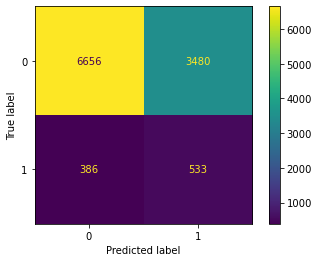

In [28]:
plot_confusion_matrix(gnb_tfidf, X_val_vec_dense, y_val)

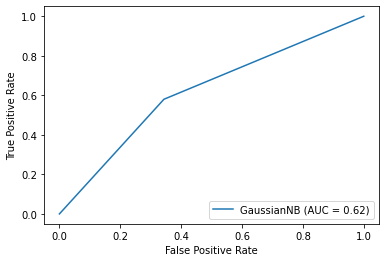

In [29]:
plot_roc_curve(gnb_tfidf, X_val_vec_dense, y_val)

In [30]:
y_hat = gnb_tfidf.predict(X_val_vec_dense)
print(classification_report(y_pred = y_hat, y_true = y_val))

              precision    recall  f1-score   support

           0       0.95      0.66      0.77     10136
           1       0.13      0.58      0.22       919

    accuracy                           0.65     11055
   macro avg       0.54      0.62      0.50     11055
weighted avg       0.88      0.65      0.73     11055



## Modeling Count Vectorizer on Naive Bayes

In [25]:
gnb_cv = GaussianNB()
gnb_cv.fit(X_cv_vec_dense, y_t)

GaussianNB()

In [26]:
gnb_cv.score(X_cv_vec_dense, y_t)

0.8190474036547856

In [27]:
gnb_cv.score(X_val_cv_vec_dense, y_val)

0.6511080958842153

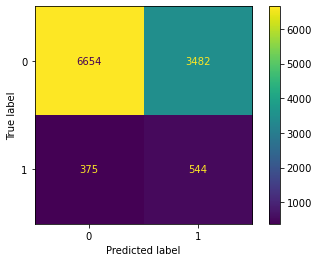

In [28]:
plot_confusion_matrix(gnb_cv, X_val_cv_vec_dense, y_val);

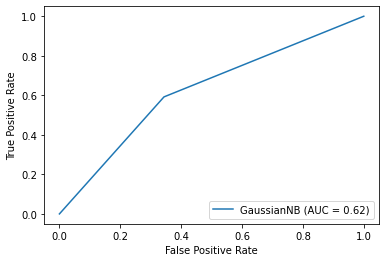

In [29]:
plot_roc_curve(gnb_cv, X_val_cv_vec_dense, y_val);

In [30]:
y_hat_3 = gnb_cv.predict(X_val_cv_vec_dense)
print(classification_report(y_pred = y_hat_3, y_true = y_val))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     10136
           1       0.14      0.59      0.22       919

    accuracy                           0.65     11055
   macro avg       0.54      0.62      0.50     11055
weighted avg       0.88      0.65      0.73     11055



## Modeling TF-IDF on Multinomial Bayes

In [31]:
multi_tfidf = MultinomialNB()
multi_tfidf.fit(X_t_vec_dense, y_t)

MultinomialNB()

In [32]:
multi_tfidf.score(X_t_vec_dense, y_t)

0.9208431337072553

In [33]:
multi_tfidf.score(X_val_vec_dense, y_val)

0.9201266395296246

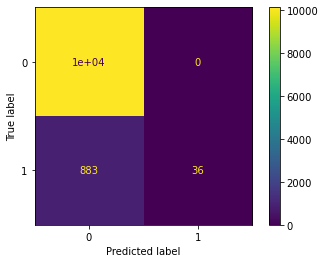

In [34]:
plot_confusion_matrix(multi_tfidf, X_val_vec_dense, y_val);

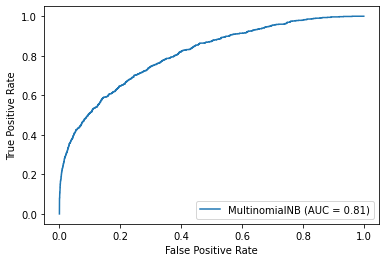

In [35]:
plot_roc_curve(multi_tfidf, X_val_vec_dense, y_val);

In [36]:
y_hat_2 = multi_tfidf.predict(X_val_vec_dense)
print(classification_report(y_pred = y_hat_2, y_true = y_val))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10136
           1       1.00      0.04      0.08       919

    accuracy                           0.92     11055
   macro avg       0.96      0.52      0.52     11055
weighted avg       0.93      0.92      0.88     11055



## Modeling Count Vectorizer on Multinomial Bayes

In [31]:
multi_cv = MultinomialNB()
multi_cv.fit(X_cv_vec_dense, y_t)

MultinomialNB()

In [32]:
multi_cv.score(X_cv_vec_dense, y_t)

0.9465804233761534

In [33]:
multi_cv.score(X_val_cv_vec_dense, y_val)

0.9305291723202171

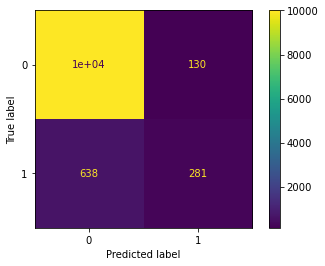

In [34]:
plot_confusion_matrix(multi_cv, X_val_cv_vec_dense, y_val);

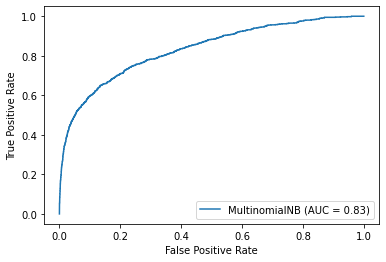

In [35]:
plot_roc_curve(multi_cv, X_val_cv_vec_dense, y_val);

In [36]:
y_hat_4 = multi_cv.predict(X_val_cv_vec_dense)
print(classification_report(y_pred = y_hat_4, y_true = y_val))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10136
           1       0.68      0.31      0.42       919

    accuracy                           0.93     11055
   macro avg       0.81      0.65      0.69     11055
weighted avg       0.92      0.93      0.92     11055



## So Far so good, time to run both Naive Bayes and Multinomial Bayes on the Entire Training Set for both TF-IDF and Count Vectorizer

In [18]:
token_test_docs = [doc_preparer(doc, sw) for doc in X_test]

#### TF-IDF on X_Train

In [19]:
tfidf_final = TfidfVectorizer()

In [20]:
X_final_t_vec = tfidf_final.fit_transform(token_docs)
X_final_t_vec = pd.DataFrame.sparse.from_spmatrix(X_final_t_vec)
X_final_t_vec.columns = sorted(tfidf_final.vocabulary_)
X_final_t_vec.set_index(y_train.index, inplace=True)

In [21]:
X_final_test_vec = tfidf_final.transform(token_test_docs)
X_final_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_vec)
X_final_test_vec.columns = sorted(tfidf_final.vocabulary_)
X_final_test_vec.set_index(y_test.index, inplace=True)

In [22]:
X_final_t_vec_dense = X_final_t_vec.sparse.to_dense()

In [23]:
X_final_test_vec_dense = X_final_test_vec.sparse.to_dense()

### Count Vectorizer on X_Train

In [19]:
cv_final = CountVectorizer()

In [20]:
X_final_c_vec = cv_final.fit_transform(token_docs)
X_final_c_vec = pd.DataFrame.sparse.from_spmatrix(X_final_c_vec)
X_final_c_vec.columns = sorted(cv_final.vocabulary_)
X_final_c_vec.set_index(y_train.index, inplace=True)

In [21]:
X_final_test_c_vec = cv_final.transform(token_test_docs)
X_final_test_c_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_c_vec)
X_final_test_c_vec.columns = sorted(cv_final.vocabulary_)
X_final_test_c_vec.set_index(y_test.index, inplace=True)

In [22]:
X_final_c_vec_dense = X_final_c_vec.sparse.to_dense()

In [23]:
X_final_test_c_vec_dense = X_final_test_c_vec.sparse.to_dense()

### Naive Bayes - TFIDF (Entire Training Set)

Impossible to run on entire dataset without crashing the notebook. Attempted on other notebook and cloud systems but it's too large to not crash

### Naive Bayes - Count Vectorizer (Entire Training Set)

Impossible to run on entire dataset without crashing the notebook. Attempted on other notebook and cloud systems but it's too large to not crash

### Multinomial Bayes - TFIDF (Entire Training Set)

In [24]:
multi_final_cv = MultinomialNB()
multi_final_cv.fit(X_final_t_vec_dense, y_train)

MultinomialNB()

In [25]:
multi_final_cv.score(X_final_t_vec_dense, y_train)

0.9213330679741637

In [26]:
multi_final_cv.score(X_final_test_vec_dense, y_test)

0.917860761325807

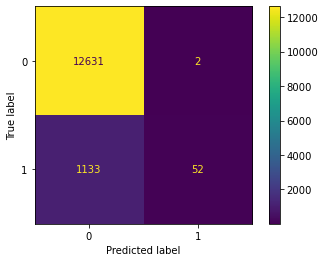

In [27]:
plot_confusion_matrix(multi_final_cv, X_final_test_vec_dense, y_test)

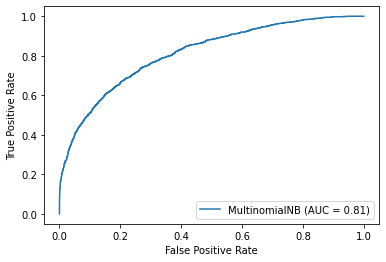

In [28]:
plot_roc_curve(multi_final_cv, X_final_test_vec_dense, y_test)

In [29]:
y_hat_5 = multi_final_cv.predict(X_final_test_vec_dense)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12633
           1       0.96      0.04      0.08      1185

    accuracy                           0.92     13818
   macro avg       0.94      0.52      0.52     13818
weighted avg       0.92      0.92      0.88     13818



### Multinomial Bayes - Count Vectorizer (Entire Training Set)

In [24]:
multi_final_cvect = MultinomialNB()
multi_final_cvect.fit(X_final_c_vec_dense, y_train)

MultinomialNB()

In [25]:
multi_final_cvect.score(X_final_c_vec_dense, y_train)

0.9454325052921062

In [26]:
multi_final_cvect.score(X_final_test_c_vec_dense, y_test)

0.9286437979447097

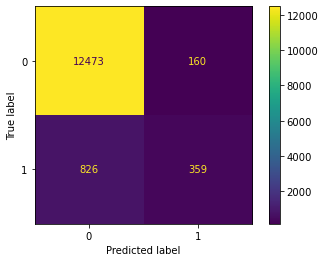

In [27]:
plot_confusion_matrix(multi_final_cvect, X_final_test_c_vec_dense, y_test)

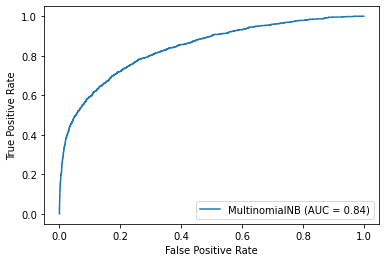

In [28]:
plot_roc_curve(multi_final_cvect, X_final_test_c_vec_dense, y_test)

In [29]:
y_hat_6 = multi_final_cvect.predict(X_final_test_c_vec_dense)
print(classification_report(y_pred = y_hat_6, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     12633
           1       0.69      0.30      0.42      1185

    accuracy                           0.93     13818
   macro avg       0.81      0.65      0.69     13818
weighted avg       0.92      0.93      0.92     13818

